In [92]:
import cv2
import pandas as pd

final_data_path = open("final_features.txt", "r")
final_data_pre = pd.read_csv(final_data_path.read().strip())

# create a new DF
def load_feature_file(filename: str) -> list[float]:
    with open(filename, 'r') as file:
        file_content = file.read()
        res = [float(item) for item in file_content.split(',')]
        return res

final_data_pre["LABEL"] = final_data_pre["class_name"]
final_data_pre["FEATURES"] = final_data_pre["file_path"].map(load_feature_file)

Convert from dataset format to
LABEL, FEATURES
"LABEL1", [1,2,3,......]

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df = pd.DataFrame(final_data_pre)
df = df.sample(frac=1).reset_index(drop=True) # Shuffle the dataframe

print("Original DataFrame head:")
print(df.head())

# extract features and labels
features = np.array(df['FEATURES'].tolist()).astype(np.float32)

# Get the string labels
labels = df['LABEL'].values

# map string labels to integers
unique_classes = np.unique(labels)
num_classes = len(unique_classes)
class_names = np.unique(labels)
class_to_idx = {class_name: i for i, class_name in enumerate(unique_classes)}
idx_to_class = {i: class_name for class_name, i in class_to_idx.items()}
integer_labels = np.array([class_to_idx[label] for label in labels])

def make_training_and_validation_loaders(test_size=0.2, random_state=42, batch_size=64, features=None, integer_labels=None, filter_by_label_fn=None, idx_to_class=None):
    # filter data if a filtering function is provided
    if filter_by_label_fn is not None:
        mask = np.array([filter_by_label_fn(
            idx_to_class[label]
        ) for label in integer_labels])
        features = features[mask]
        integer_labels = integer_labels[mask]

    X_train, X_val, y_train, y_val = train_test_split(
        features, integer_labels, test_size=0.2, stratify=integer_labels
    )

    # scale features using MinMaxScaler
    # which is important for neural networks
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    class MainDataset(Dataset):
        def __init__(self, features, labels):
            self.features = torch.tensor(features, dtype=torch.float32)
            self.labels = torch.tensor(labels, dtype=torch.long)
        def __len__(self):
            return len(self.features)
        def __getitem__(self, idx):
            return self.features[idx], self.labels[idx]
        
        
    # create DataLoaders to handle batching and incremental loading of data

    train_dataset = MainDataset(X_train, y_train)
    val_dataset = MainDataset(X_val, y_val)

    batch_size = 64
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def banana_only(label: str) -> bool:
    return "banana" in label.lower()

def avocado_only(label: str) -> bool:
    return "avocado" in label.lower() or "alpukat" in label.lower()

train_loader, val_loader = make_training_and_validation_loaders(features=features, integer_labels=integer_labels, idx_to_class=idx_to_class)

# Get the number of features from the data shape
num_features = features.shape[1]

Original DataFrame head:
                                     id             class_name  \
0  53dcd9472a401c2a0da3585f5d613acd.png  avocado_overripe_self   
1  aa979bbd96684f0f332eac9810cdd5f4.png  avocado_overripe_self   
2  61927feddd07b656cb05a278adf109f1.png    alpukat_ripe_google   
3  7adb7bf84157b7c9c7322cc45bb49e84.png  avocado_breaking_self   
4  09103224cfbc0ea486bbdeb4ae21bf3d.png      avocado_ripe_self   

                                           file_path resolution  \
0  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
1  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
2  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    780x438   
3  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
4  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   

                   LABEL                                           FEATURES  
0  avocado_overripe_self  [0.3134286105632782, 0.30908292531967163, 0.01...  
1  avocado_overripe

In [94]:
df

id             class_name  \
0     53dcd9472a401c2a0da3585f5d613acd.png  avocado_overripe_self   
1     aa979bbd96684f0f332eac9810cdd5f4.png  avocado_overripe_self   
2     61927feddd07b656cb05a278adf109f1.png    alpukat_ripe_google   
3     7adb7bf84157b7c9c7322cc45bb49e84.png  avocado_breaking_self   
4     09103224cfbc0ea486bbdeb4ae21bf3d.png      avocado_ripe_self   
...                                    ...                    ...   
3821  483b5210c87ede98ac8190c08f437ee5.png      avocado_ripe_self   
3822  90219e990bfe71d727b3f1454b08b66d.png  avocado_breaking_self   
3823  c3d946ebae4ecb031b36e1bde03e1935.png      avocado_firm_self   
3824  1ebeef18e0c52625575988bfcd03db40.png  avocado_overripe_self   
3825  0b53a0589922f0880f268013840fc915.png       banana_day5_self   

                                              file_path resolution  \
0     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
1     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
2     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...    780x438   
3     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
4     /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
...                                                 ...        ...   
3821  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
3822  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
3823  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
3824  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...  1920x1080   
3825  /home/fadhlan/Normal2/DeepLearningRepo/steps/v...   720x1280   

                      LABEL                                           FEATURES  
0     avocado_overripe_self  [0.3134286105632782, 0.30908292531967163, 0.01...  
1     avocado_overripe_self  [2.0463027954101562, 0.1846625655889511, 0.295...  
2       alpukat_ripe_google  [3.000192403793335, 0.13190047442913055, 2.736...  
3     avocado_breaking_self  [0.6567658185958862, 0.28863054513931274, 0.81...  
4         avocado_ripe_self  [1.0511740446090698, 0.394598126411438, 0.1522...  
...                     ...                                                ...  
3821      avocado_ripe_self  [0.3860829472541809, 0.5327115654945374, 1.292...  
3822  avocado_breaking_self  [1.7733113765716553, 0.018165165558457375, 0.3...  
3823      avocado_firm_self  [3.6906282901763916, 0.9079715609550476, 0.120...  
3824  avocado_overripe_self  [1.088780403137207, 0.8253252506256104, 0.4434...  
3825       banana_day5_self  [0.5970598459243774, 0.804200291633606, 0.6129...  

[3826 rows x 6 columns]

In [95]:
class BasicFeatureBasedClassifier(nn.Module):
    def __init__(self, input_features, num_classes):
        super(BasicFeatureBasedClassifier, self).__init__()
        self.layer1 = nn.Linear(input_features, 64) 
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(64, 48)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(48, 128)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

model = BasicFeatureBasedClassifier(input_features=num_features, num_classes=num_classes)
print(f"\nModel Architecture:\n{model}")


Model Architecture:
BasicFeatureBasedClassifier(
  (layer1): Linear(in_features=2048, out_features=64, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=64, out_features=48, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=48, out_features=128, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=128, out_features=13, bias=True)
)


In [96]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 15
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    for features, labels in train_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Simple validation check at the end of each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2f}%")

print("done training!")

# save output for Netron
torch.save(model.state_dict(), "feature_based_model.pth")

Epoch [1/15], Loss: 1.1630, Validation Accuracy: 50.26%
Epoch [2/15], Loss: 0.5119, Validation Accuracy: 78.72%
Epoch [3/15], Loss: 0.4947, Validation Accuracy: 83.29%
Epoch [4/15], Loss: 0.2375, Validation Accuracy: 90.60%
Epoch [5/15], Loss: 0.2301, Validation Accuracy: 92.56%
Epoch [6/15], Loss: 0.1306, Validation Accuracy: 94.39%
Epoch [7/15], Loss: 0.1329, Validation Accuracy: 95.17%
Epoch [8/15], Loss: 0.0741, Validation Accuracy: 94.91%
Epoch [9/15], Loss: 0.0842, Validation Accuracy: 96.34%
Epoch [10/15], Loss: 0.1178, Validation Accuracy: 95.56%
Epoch [11/15], Loss: 0.0640, Validation Accuracy: 96.61%
Epoch [12/15], Loss: 0.1021, Validation Accuracy: 96.08%
Epoch [13/15], Loss: 0.0543, Validation Accuracy: 95.82%
Epoch [14/15], Loss: 0.0926, Validation Accuracy: 95.95%
Epoch [15/15], Loss: 0.0265, Validation Accuracy: 96.08%
done training!


In [106]:
def show_predictions(model, loader, idx_to_class_map, num_to_show=5):
    model.eval()  
    predictions_shown = 0
    print(f"Showing predictions for the first {num_to_show} samples...")
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features)
            _, predicted_indices = torch.max(outputs, 1)
            for i in range(features.shape[0]):
                if predictions_shown >= num_to_show:
                    return 
                actual_label = idx_to_class_map[labels[i].item()]
                predicted_label = idx_to_class_map[predicted_indices[i].item()]
                status = "V Correct" if actual_label == predicted_label else "❌ Incorrect"
                print(f"  Sample {predictions_shown + 1}: Actual: {actual_label:<8} | Predicted: {predicted_label:<8} | Status: {status}")
                predictions_shown += 1

print("\nPredictions on Training Set:")
show_predictions(model, train_loader, idx_to_class, num_to_show=20)
print("\nPredictions on Validation Set:")
show_predictions(model, val_loader, idx_to_class, num_to_show=20)


Predictions on Training Set:
Showing predictions for the first 20 samples...
  Sample 1: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: V Correct
  Sample 2: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: V Correct
  Sample 3: Actual: avocado_overripe_self | Predicted: avocado_overripe_self | Status: V Correct
  Sample 4: Actual: alpukat_ripe_google | Predicted: alpukat_unripe_google | Status: ❌ Incorrect
  Sample 5: Actual: banana_day7_self | Predicted: banana_day7_self | Status: V Correct
  Sample 6: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: V Correct
  Sample 7: Actual: alpukat_unripe_google | Predicted: alpukat_unripe_google | Status: V Correct
  Sample 8: Actual: alpukat_unripe_google | Predicted: alpukat_unripe_google | Status: V Correct
  Sample 9: Actual: avocado_breaking_self | Predicted: avocado_breaking_self | Status: V Correct
  Sample 10: Actual: avocado_firm_self | Predicted: avocado_firm_self | Status: V C

torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([62, 2048])


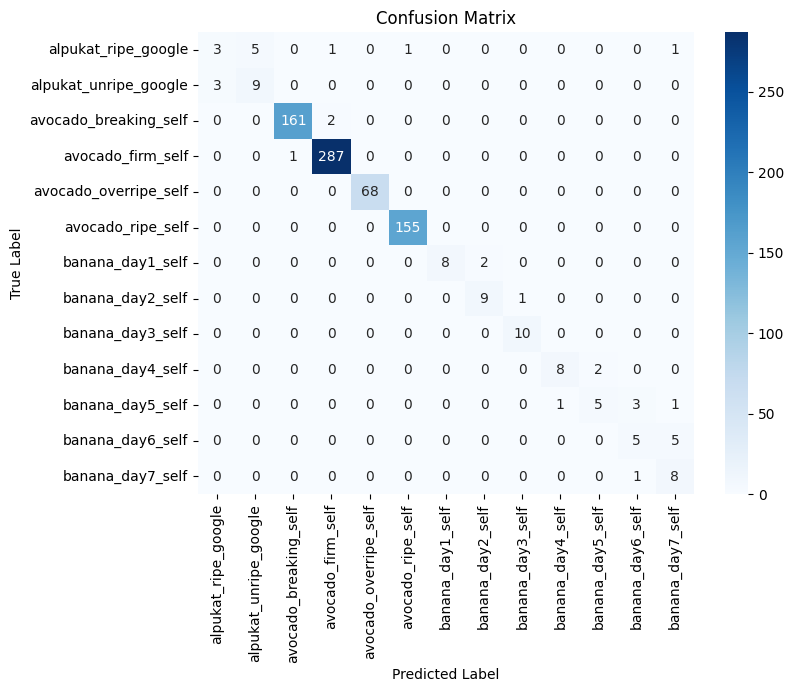

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# --- 5. GENERATE AND VISUALIZE CONFUSION MATRIX ---

# Lists to store all true labels and predictions from the validation set
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad(): 
    for features, labels in val_loader:
        print(features.shape)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
            

# Calculate the confusion matrix using scikit-learn
cm = confusion_matrix(all_labels, all_predictions)

# Create a figure and an axes for the plot
plt.figure(figsize=(8, 6))

# Use seaborn to create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

# Add labels and a title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

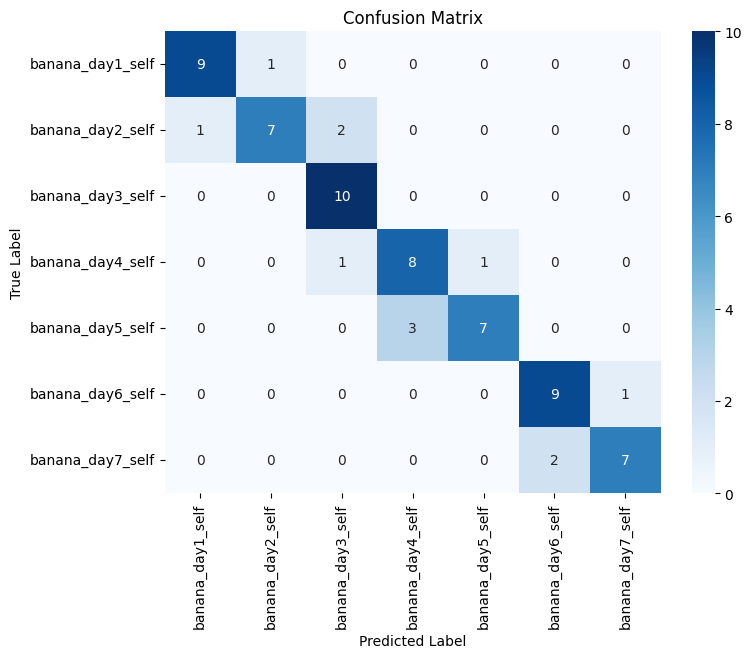

In [ ]:
# show the banana only confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# --- 5. GENERATE AND VISUALIZE CONFUSION MATRIX ---

# Lists to store all true labels and predictions from the validation set
def run_confusion_matrix(val_loader, idx_to_class, class_names, allowed_label_fn=lambda x: True):
    all_labels = []
    all_predictions = []

    model.eval()
    with torch.no_grad(): 
        for features, labels in val_loader:
            # filter to only banana samples
            mask = np.array([allowed_label_fn(
                idx_to_class[label.item()]
            ) for label in labels])
            features = features[mask]
            labels = labels[mask]
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix using scikit-learn
    cm = confusion_matrix(all_labels, all_predictions)

    # Create a figure and an axes for the plot
    plt.figure(figsize=(8, 6))
    internal_class_names = [name for name in class_names if allowed_label_fn(name)]

    # Use seaborn to create a heatmap for the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=internal_class_names, yticklabels=internal_class_names)
    # Add labels and a title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()
run_confusion_matrix(val_loader, idx_to_class, class_names, allowed_label_fn=banana_only)


--- Validation Set Predictions with Images ---

=== Correct Predictions (Showing max 30) ===


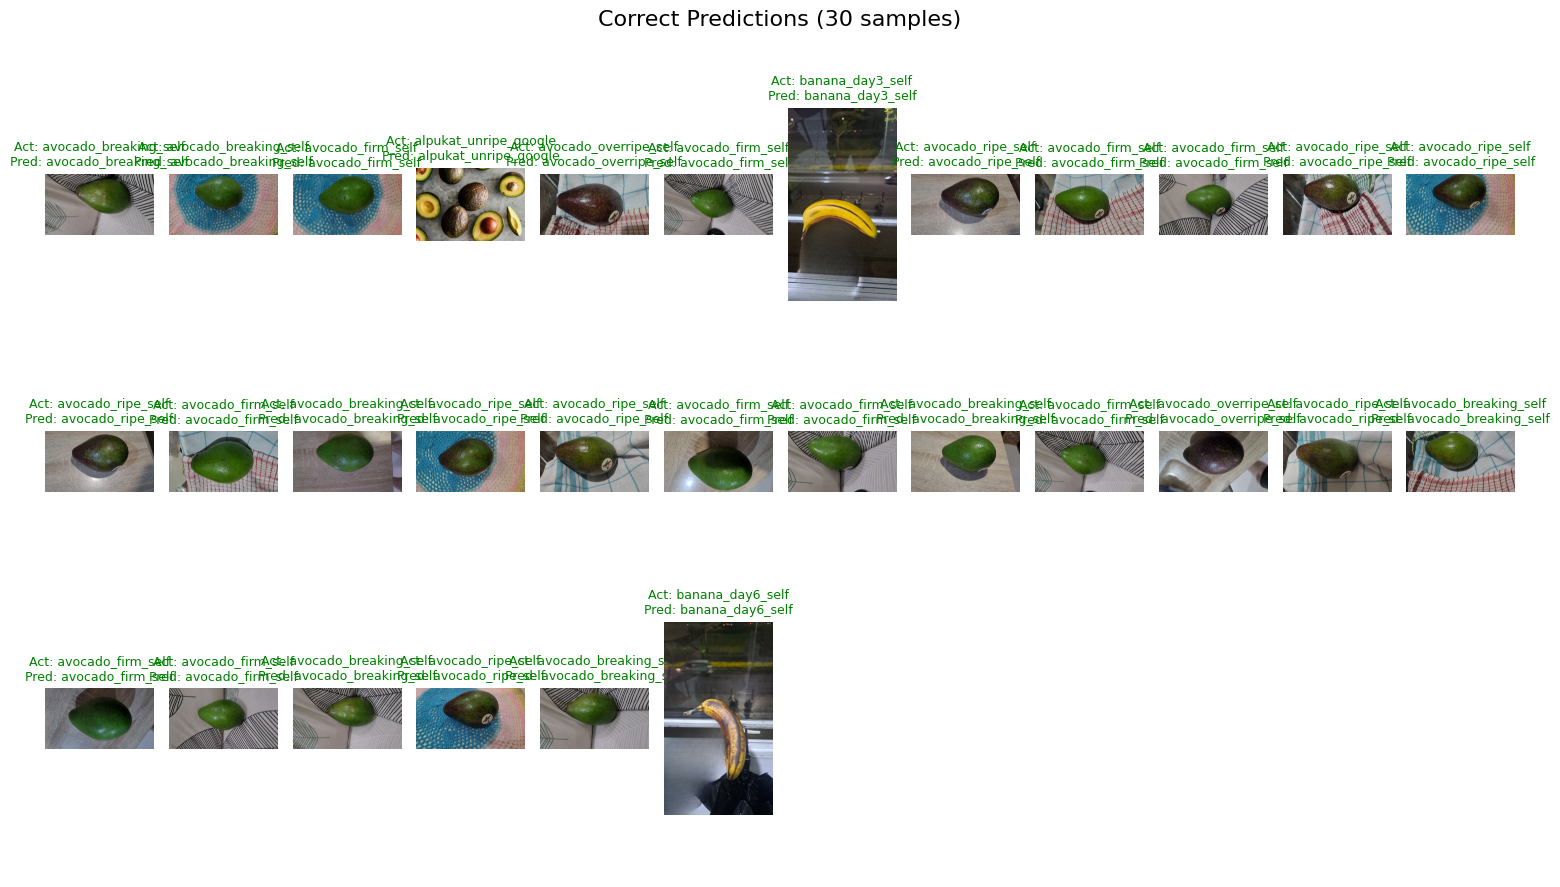


=== Incorrect Predictions (Showing max 30) ===


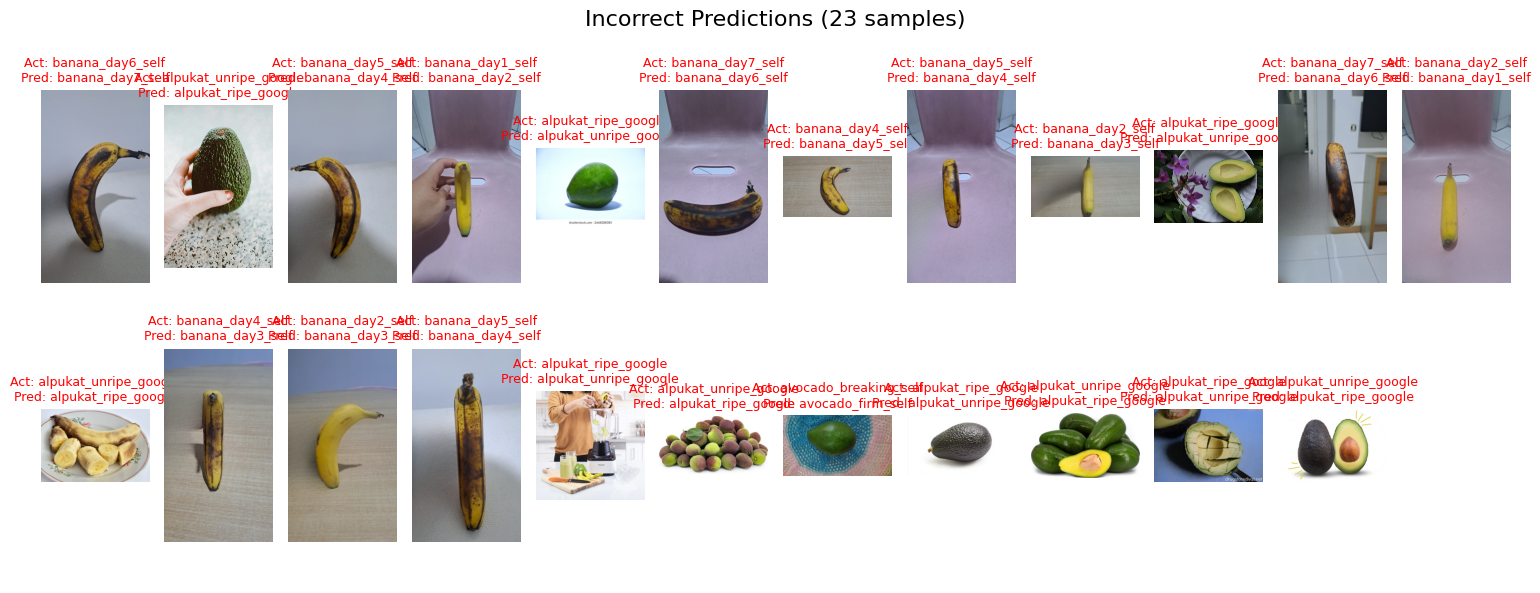


--- Training Set Predictions with Images ---

=== Correct Predictions (Showing max 30) ===


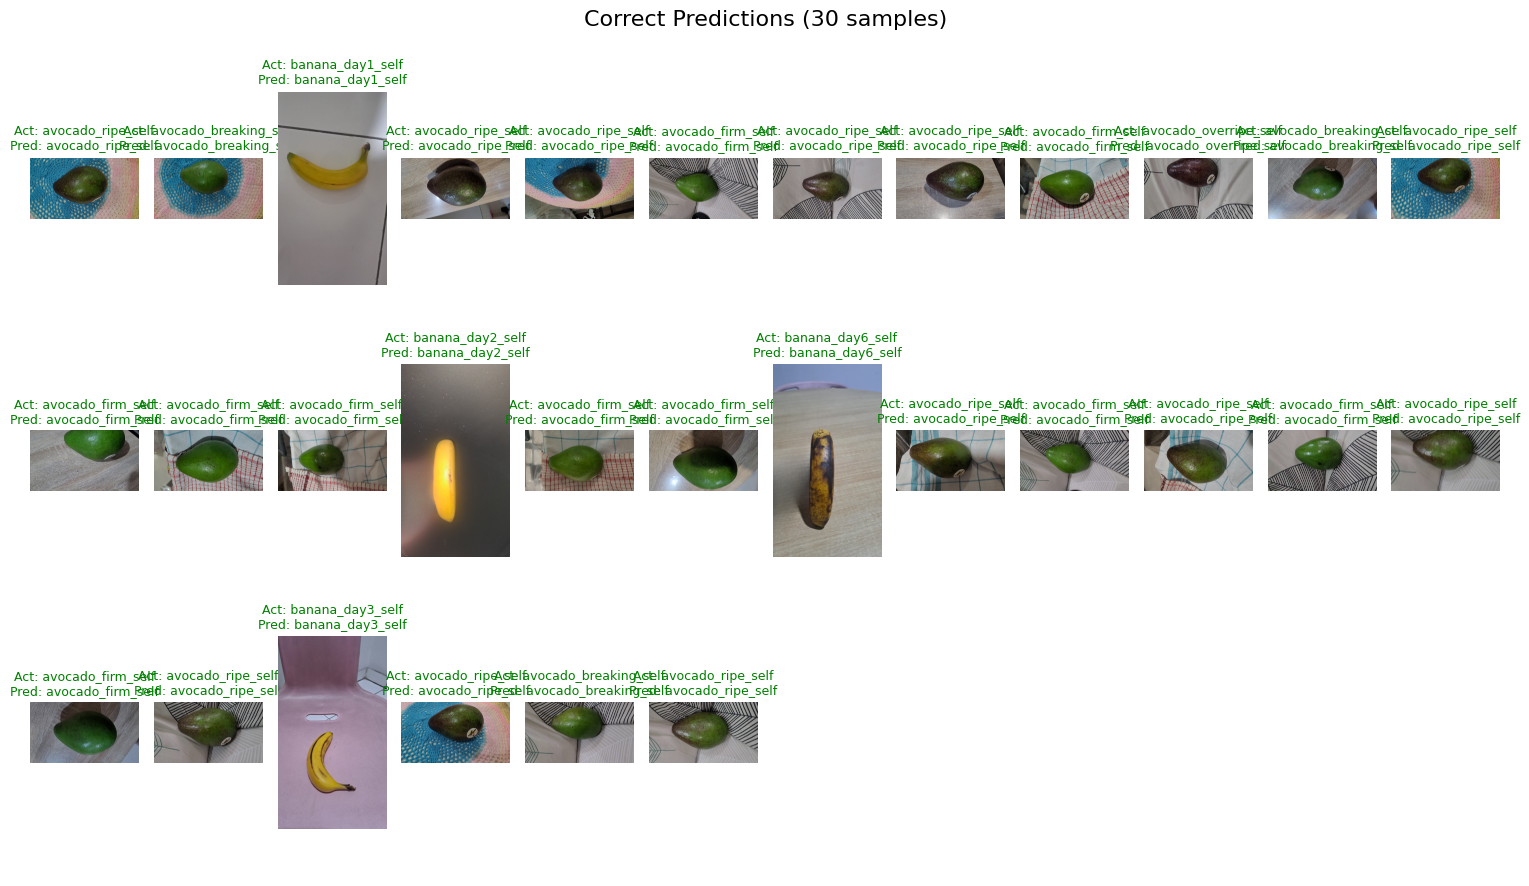


=== Incorrect Predictions (Showing max 30) ===


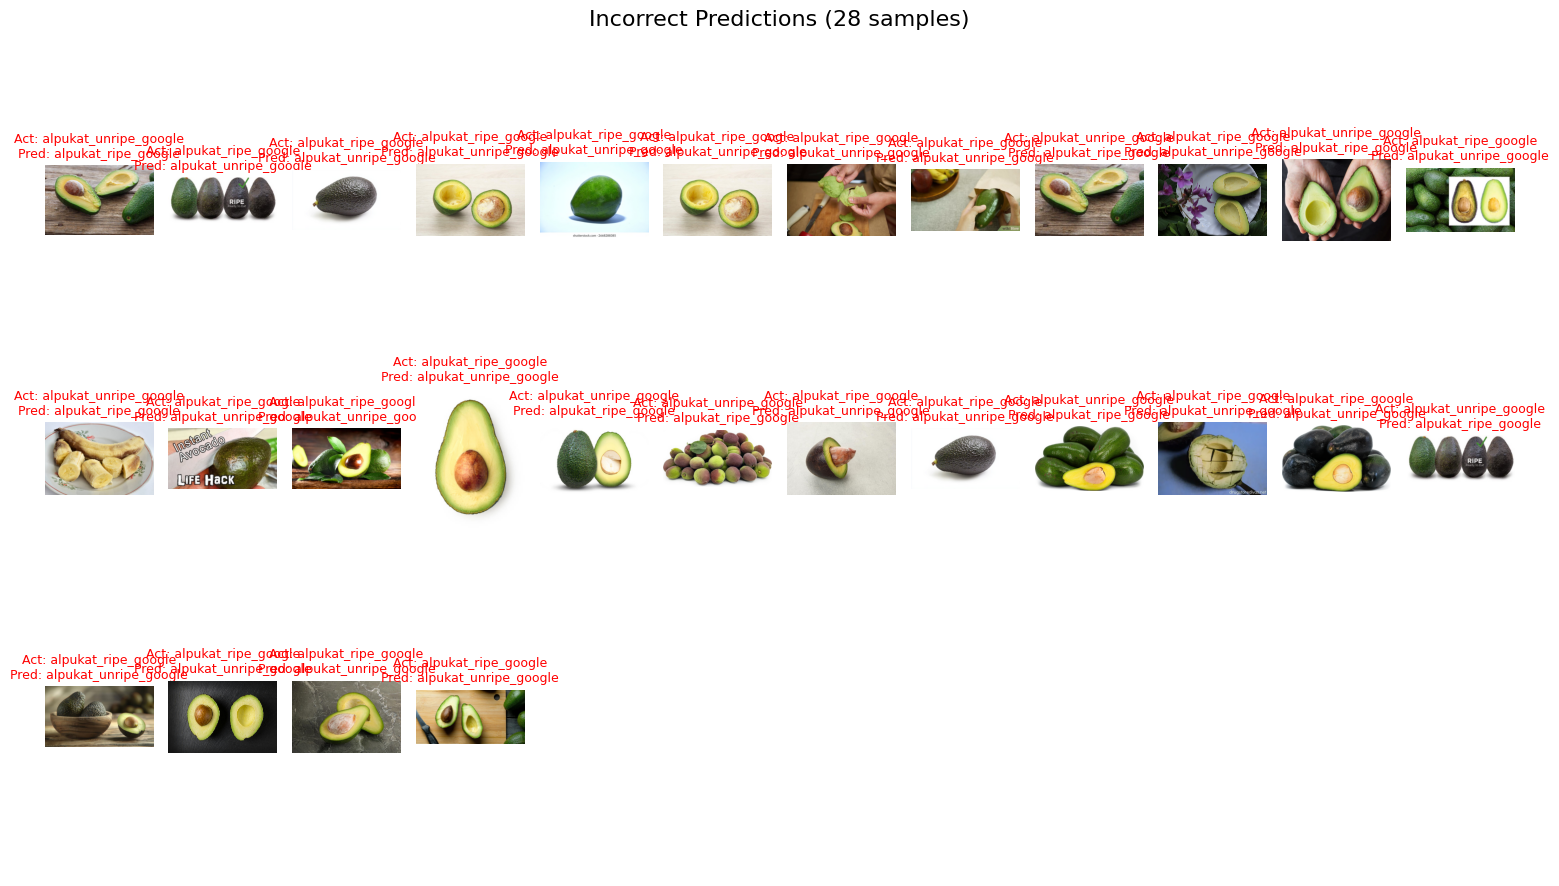

In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- 6. VISUALIZE CORRECT AND INCORRECT PREDICTIONS IN A GRID WITH IMAGES ---

def show_predictions_grid(model, loader, idx_to_class_map, num_samples=30):
    model.eval()
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features)
            _, predicted_indices = torch.max(outputs, 1)
            for i in range(features.shape[0]):
                # Stop if we have enough of both
                if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                    break
                actual_idx = labels[i].item()
                pred_idx = predicted_indices[i].item()
                is_correct = (actual_idx == pred_idx)
                item = {
                    'actual_label': idx_to_class_map[actual_idx],
                    'predicted_label': idx_to_class_map[pred_idx],
                    'is_correct': is_correct
                }
                if is_correct:
                    if len(correct_samples) < num_samples:
                        correct_samples.append(item)
                else:
                    if len(incorrect_samples) < num_samples:
                        incorrect_samples.append(item)
            if len(correct_samples) >= num_samples and len(incorrect_samples) >= num_samples:
                break
    def plot_group(samples, title):
        if not samples:
            print(f"No samples for: {title}")
            return
        count = len(samples)
        cols = 12
        rows = (count + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        if count == 1: axes = [axes]
        else: axes = axes.flatten()
        fig.suptitle(f"{title} ({count} samples)", fontsize=16)
        for idx, item in enumerate(samples):
            ax = axes[idx]
            actual_label = item['actual_label']
            predicted_label = item['predicted_label']
            is_correct = item['is_correct']
            subset = df[df['LABEL'] == actual_label]
            if not subset.empty:
                matching_row = subset.iloc[idx % len(subset)]
                if 'id' in matching_row:
                    img_path = "./sub/paralells/steps/convertedtemp/" + str(matching_row['id'])
                elif 'file_path' in matching_row:
                    img_path = matching_row['file_path']
                else:
                    img_path = None
                if img_path:
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            ax.imshow(img)
                        else:
                            ax.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center')
                    except:
                        ax.text(0.5, 0.5, 'Error', ha='center', va='center')
                else:
                    ax.text(0.5, 0.5, 'No Path', ha='center', va='center')
            else:
                ax.text(0.5, 0.5, 'No Class Data', ha='center', va='center')
            color = 'green' if is_correct else 'red'
            ax.set_title(f"Act: {actual_label}\nPred: {predicted_label}", color=color, fontsize=9)
            ax.axis('off')
        for i in range(count, len(axes)):
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
    print(f"\n=== Correct Predictions (Showing max {num_samples}) ===")
    plot_group(correct_samples, "Correct Predictions")
    print(f"\n=== Incorrect Predictions (Showing max {num_samples}) ===")
    plot_group(incorrect_samples, "Incorrect Predictions")

print("--- Validation Set Predictions with Images ---")
show_predictions_grid(model, val_loader, idx_to_class,num_samples=30)

print("\n--- Training Set Predictions with Images ---")
show_predictions_grid(model, train_loader, idx_to_class, num_samples=30)

In [104]:
print(model)

BasicFeatureBasedClassifier(
  (layer1): Linear(in_features=2048, out_features=64, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=64, out_features=48, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=48, out_features=128, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=128, out_features=13, bias=True)
)
